In [16]:
import sys
sys.path.append("../../BayesFlow")
sys.path.append("../")

import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import numpy as np
import pickle

import keras
import seaborn as sns

import matplotlib.pyplot as plt


parent_dir = '/home/administrator/Documents/BF-LIGHT'



In [2]:
import bayesflow as bf
from dmc import DMC, dmc_helpers


with torch.enable_grad():
in contexts where you need gradients (e.g. custom training loops).


In [3]:
simulator = DMC(
    prior_means=np.array([16., 111., 0.5, 322., 75.]), 
    prior_sds=np.array([10., 47., 0.13, 40., 23.]),
    tmax=1500
)

In [17]:
approximator = keras.saving.load_model(parent_dir + "/data/training_ceckpoints/optuna_run1.keras")


ValueError: File not found: filepath=/home/administrator/Documents/BF-LIGHT/data/training_ceckpoints/optuna_run1.keras. Please ensure the file is an accessible `.keras` zip file.

In [5]:
import pandas as pd

narrow_data = pd.read_csv('../data/model_data/experiment_data_narrow.csv')
wide_data = pd.read_csv('../data/model_data/experiment_data_wide.csv')

empirical_data = pd.concat([narrow_data, wide_data])

In [ ]:
samples_narrow=dmc_helpers.fit_empirical_data(narrow_data, approximator)

samples_narrow["spacing"]="narrow"

samples_wide=dmc_helpers.fit_empirical_data(wide_data, approximator)

samples_wide["spacing"]="wide"

samples_complete=pd.concat((samples_wide, samples_narrow))

In [ ]:
parts=samples_complete["participant"].unique()

samples_complete

A         tau      mu_c          t0          b  participant  \
0    13.377090   83.000748  0.519483  286.294983  70.940384         1108   
1     4.771200   81.932755  0.532089  285.398590  70.273048         1108   
2     9.825678   83.611916  0.593436  285.746887  72.594002         1108   
3     9.769639   39.911316  0.579134  285.097351  74.035988         1108   
4     9.125196   70.752937  0.537078  283.844360  76.604774         1108   
..         ...         ...       ...         ...        ...          ...   
995  13.153294  173.309128  0.616802  310.408783  89.133163       337788   
996  17.672052  167.696838  0.594180  313.775696  83.827850       337788   
997  22.831154  137.333130  0.624958  312.427307  87.729904       337788   
998  16.357933  153.155350  0.639187  310.635193  92.774239       337788   
999  13.725128  125.322838  0.658256  312.417114  91.646011       337788   

     sampling_time spacing  
0         0.017486    wide  
1         0.017486    wide  
2         0.017486    wide  
3         0.017486    wide  
4         0.017486    wide  
..             ...     ...  
995       0.017060  narrow  
996       0.017060  narrow  
997       0.017060  narrow  
998       0.017060  narrow  
999       0.017060  narrow  

[134000 rows x 8 columns]

## Posterior Predictive Check

In [ ]:
def resim_data(post_sample_data, num_obs, num_resims = 50, param_names = ["A", "tau", "mu_c", "t0", "b"]):
    
    # generate random indices for random draws of posterior samples for resimulation
    random_idx = np.random.choice(np.arange(0,num_resims), size = num_resims)

    # select posterior samples
    resim_samples = post_sample_data.iloc[random_idx][param_names]

    # adjust number of trials in simulator (should be equal to the number of trials in the empirical data)
    simulator.num_obs=num_obs

    list_resim_dfs = []

    # resimulate
    for i in range(num_resims):
        resim =  simulator.experiment(A=resim_samples["A"].values[i],
                                tau=resim_samples["tau"].values[i],
                                mu_c=resim_samples["mu_c"].values[i],
                                mu_r=resim_samples["t0"].values[i],
                                b=resim_samples["b"].values[i])
        
        resim_df = pd.DataFrame(resim)
        
        resim_df["num_resim"] = i
        resim_df["partricipant"] = part
        
        list_resim_dfs.append(pd.DataFrame(resim_df))

    resim_complete = pd.concat(list_resim_dfs)
    
    return resim_complete

In [28]:
empirical_accuracies_congruent = []
empirical_accuracies_incongruent = []

resimulated_accuracies_congruent = []
resimulated_accuracies_incongruent = []


/tmp/ipykernel_16883/620438346.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1,2, figsize=(10,3))


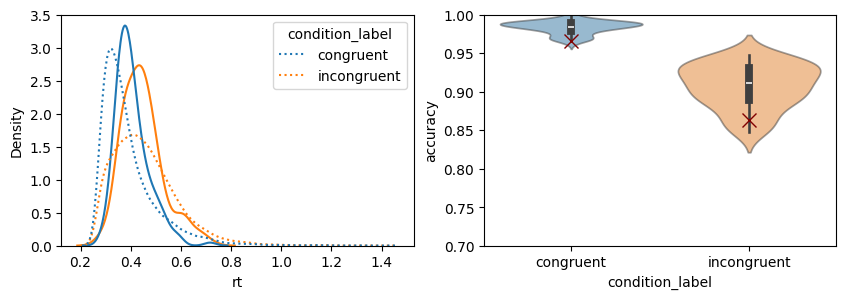

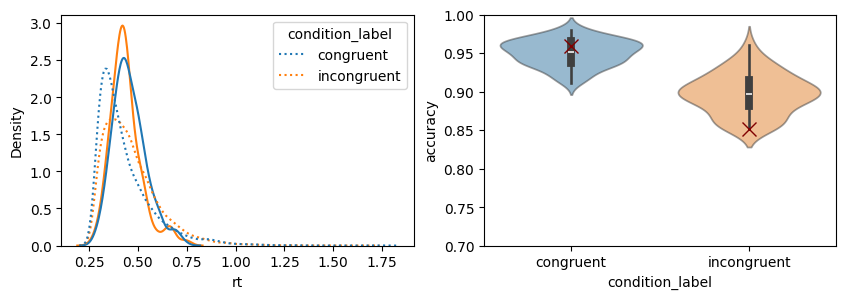

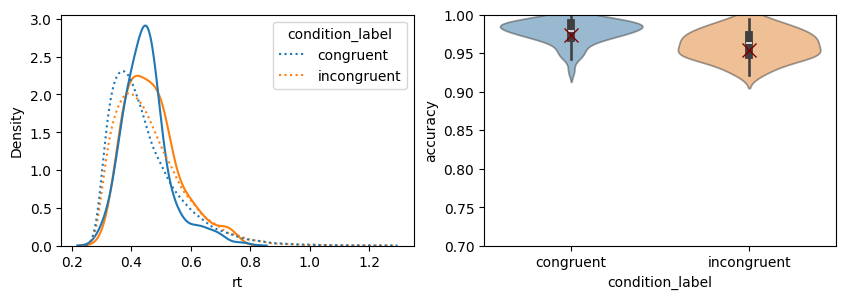

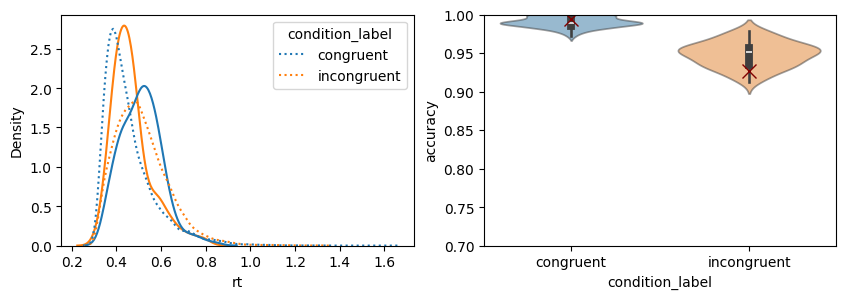

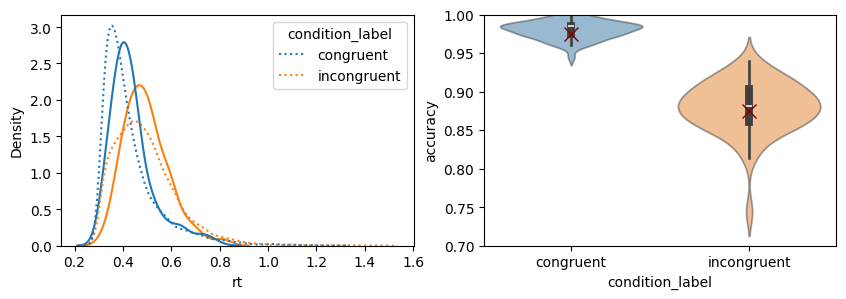

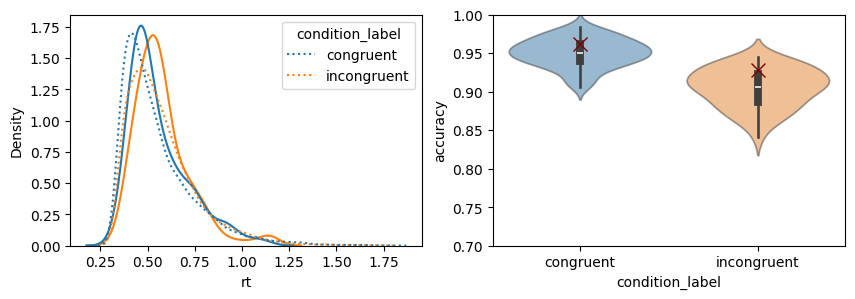

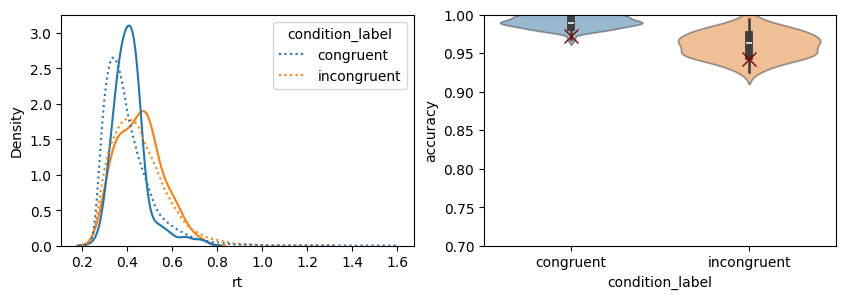

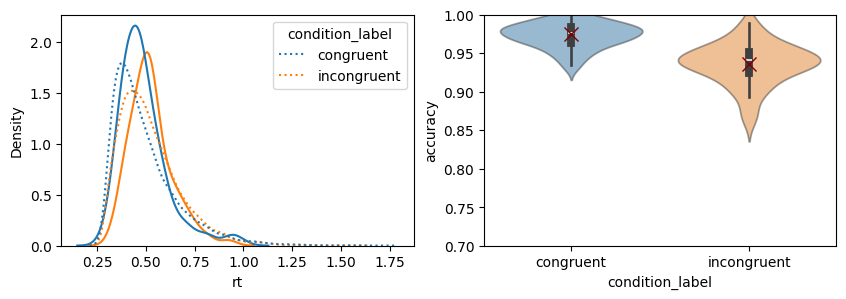

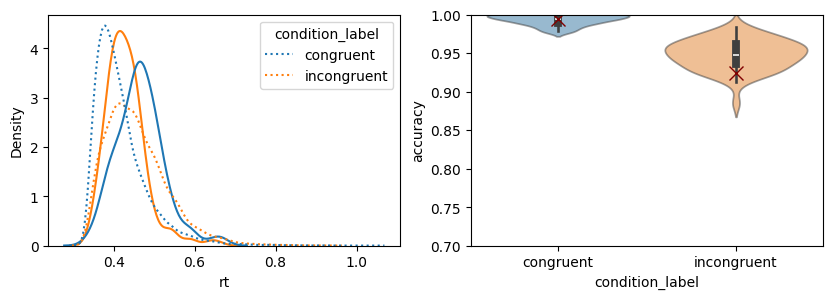

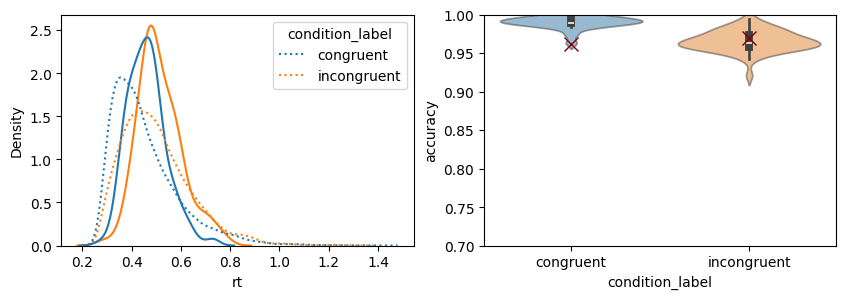

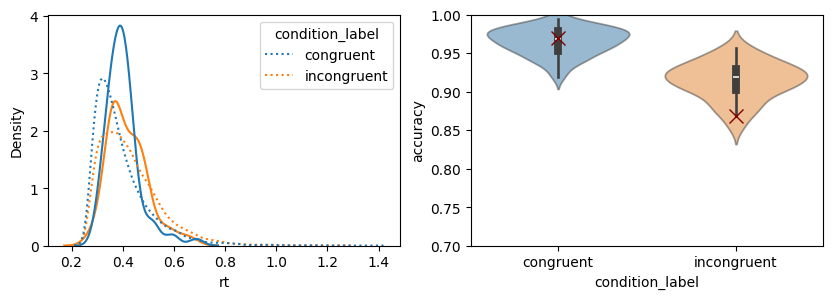

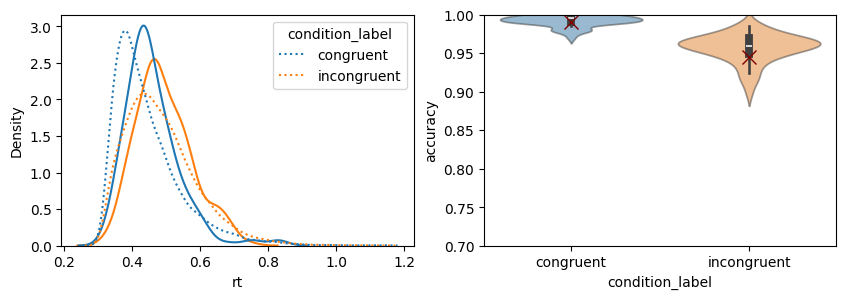

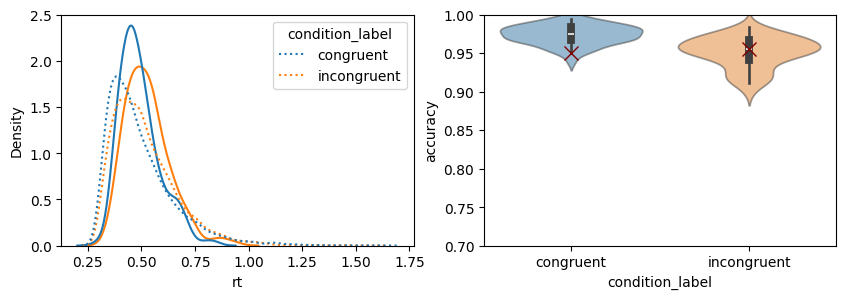

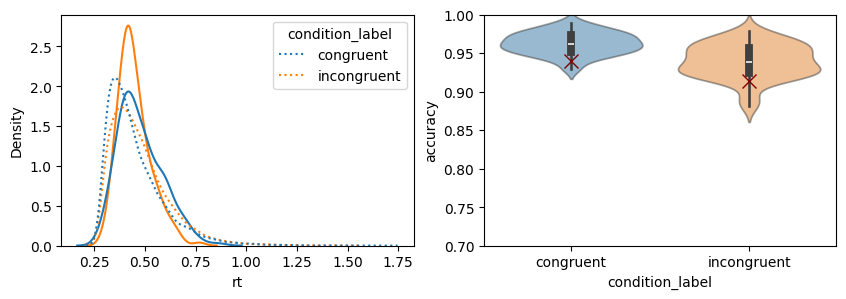

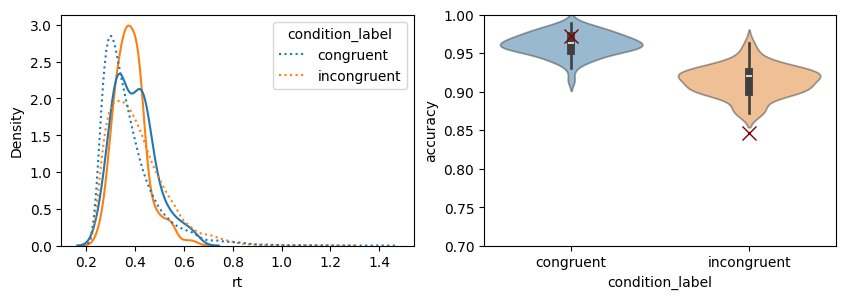

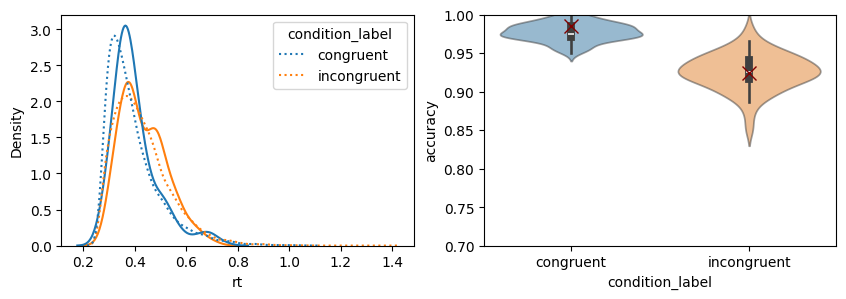

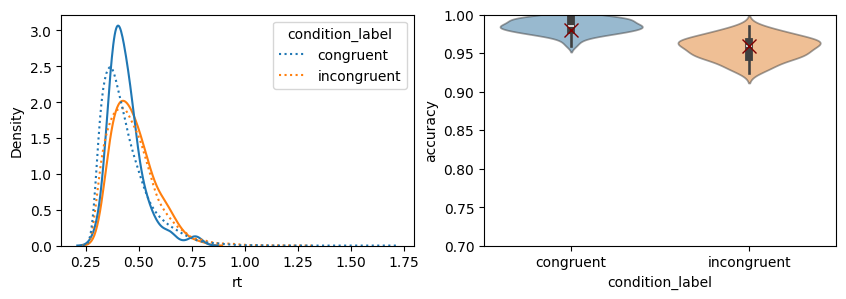

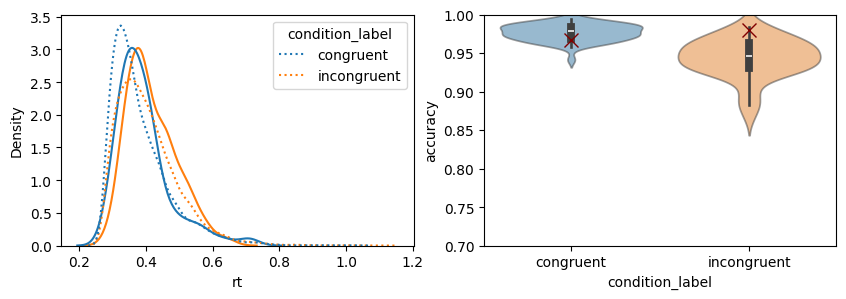

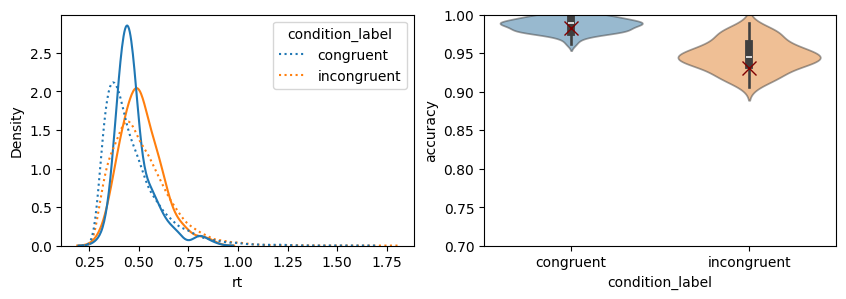

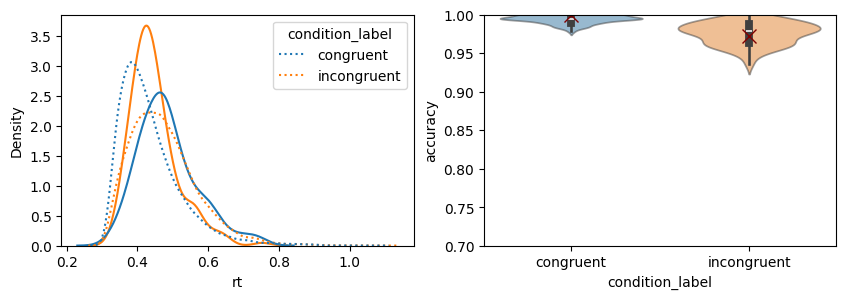

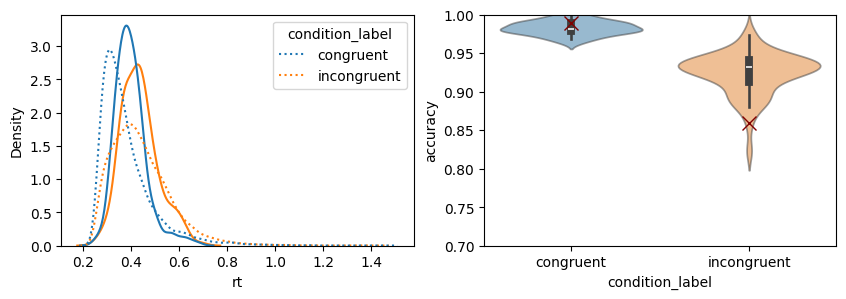

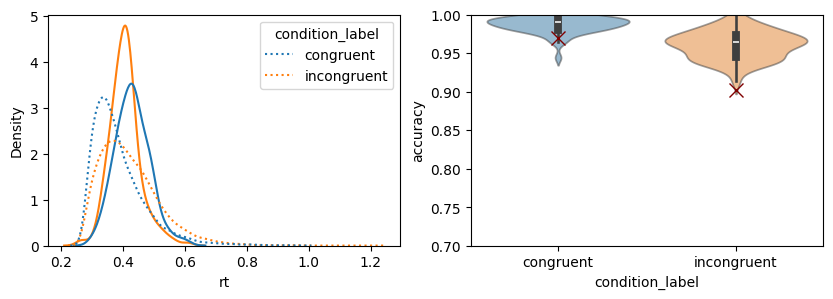

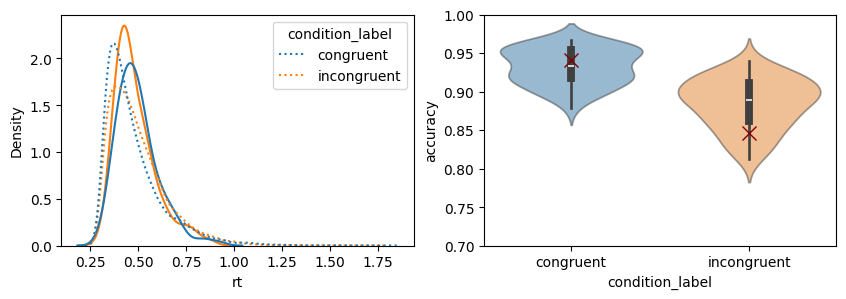

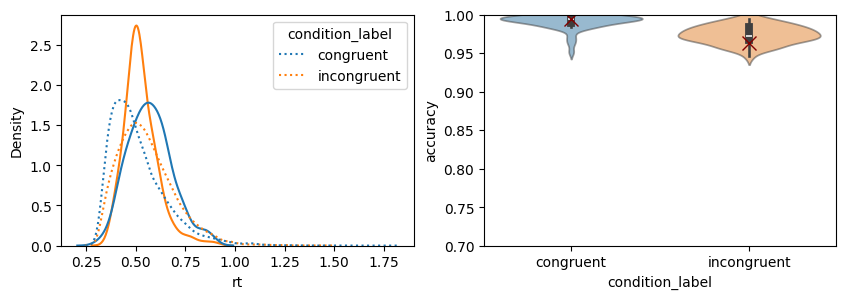

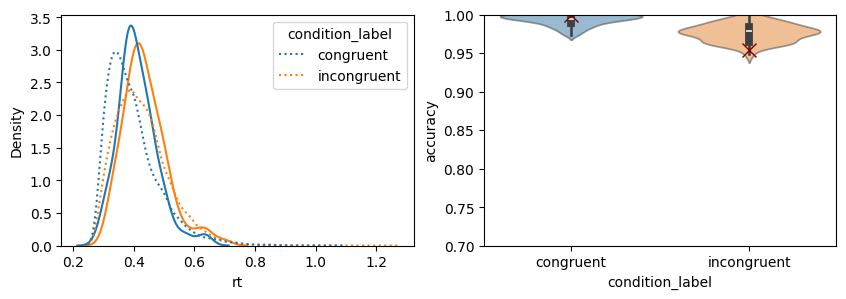

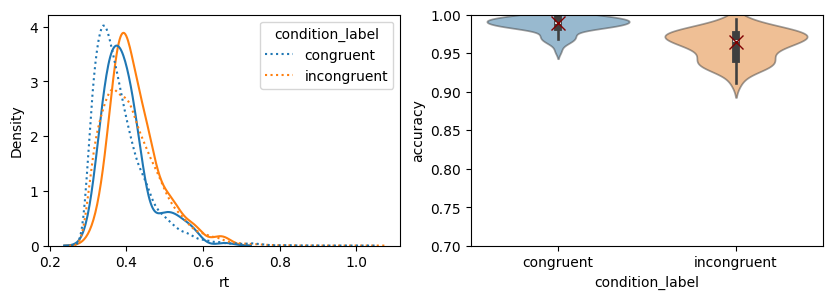

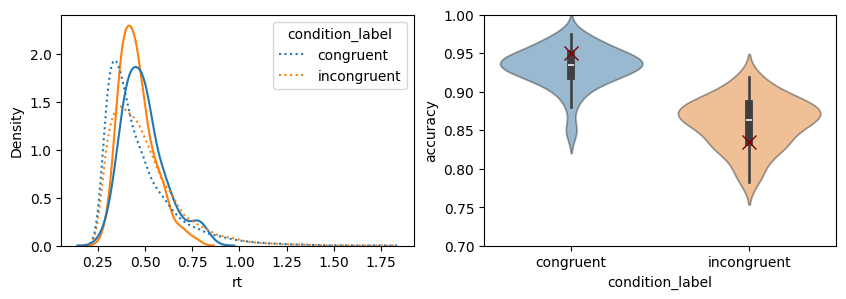

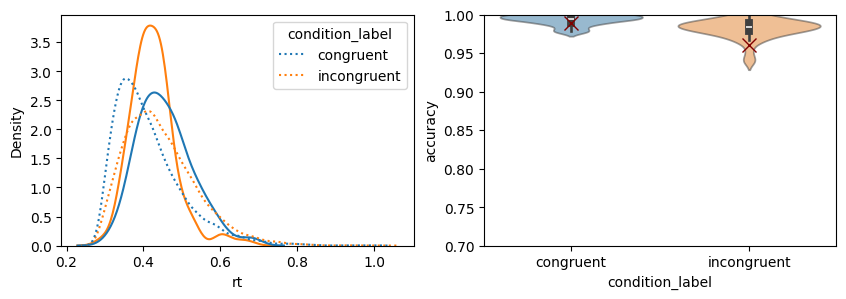

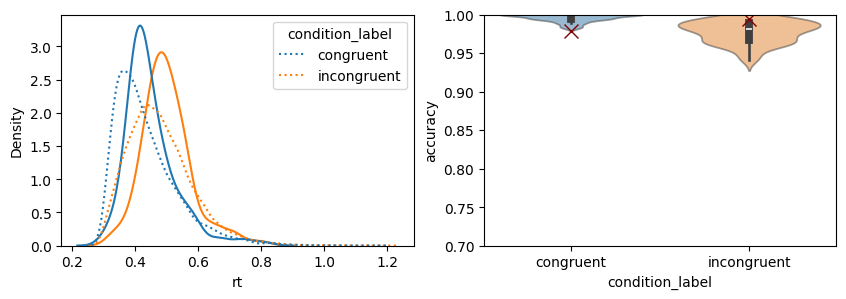

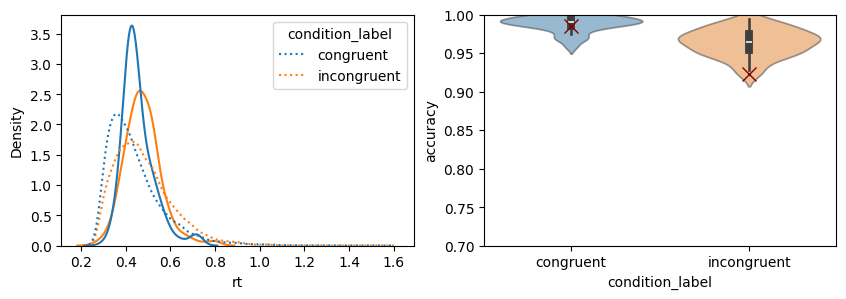

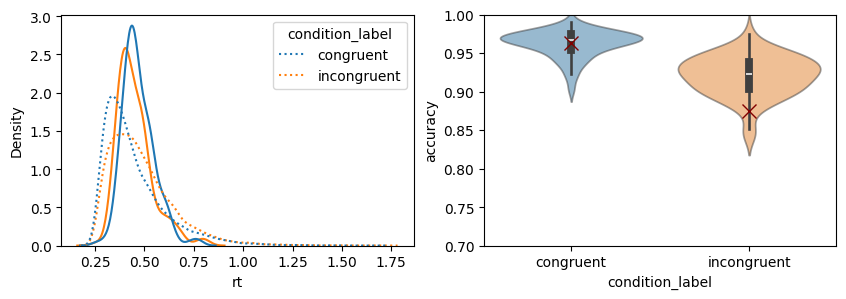

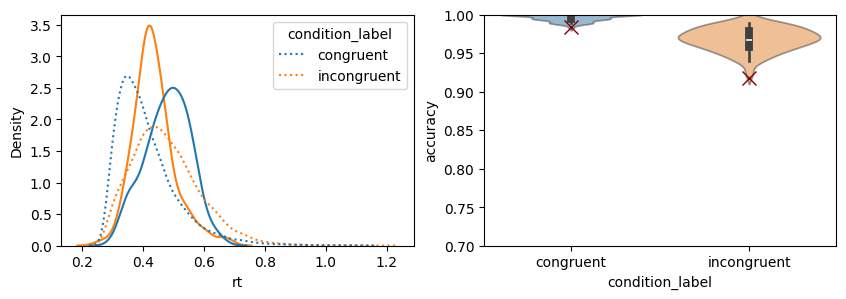

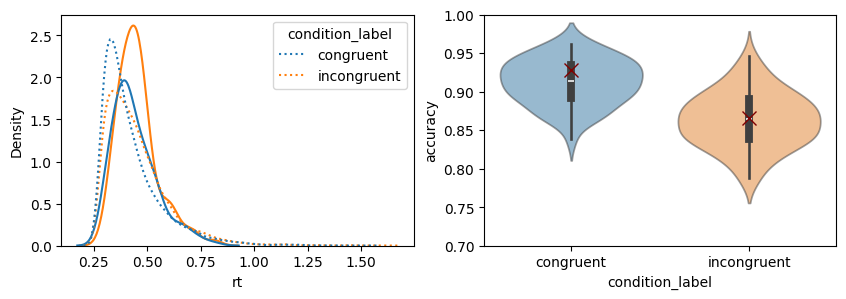

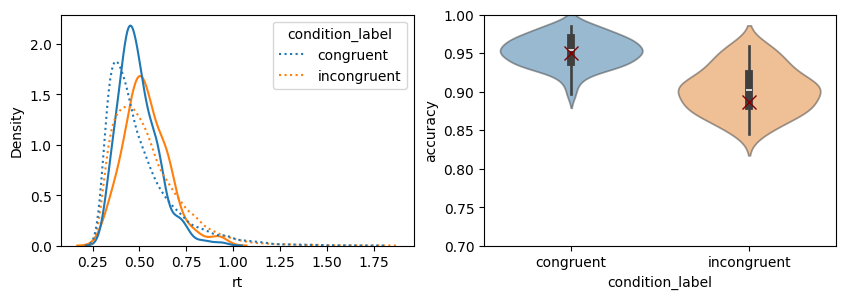

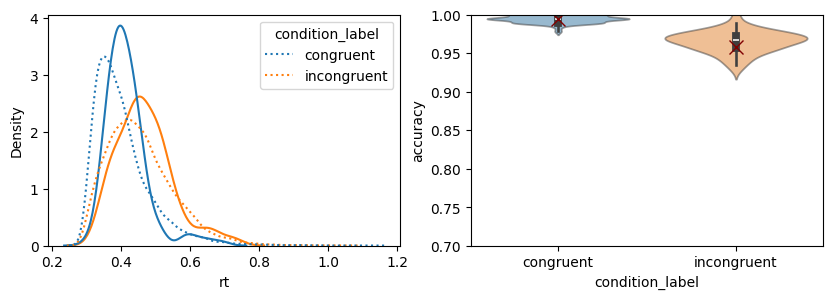

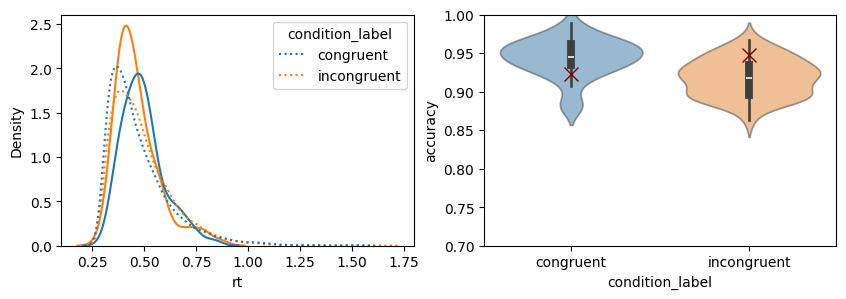

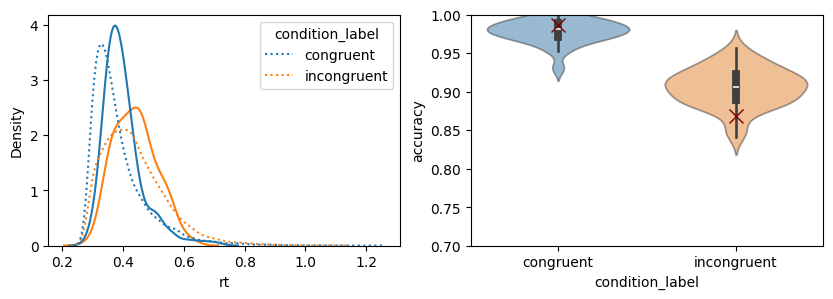

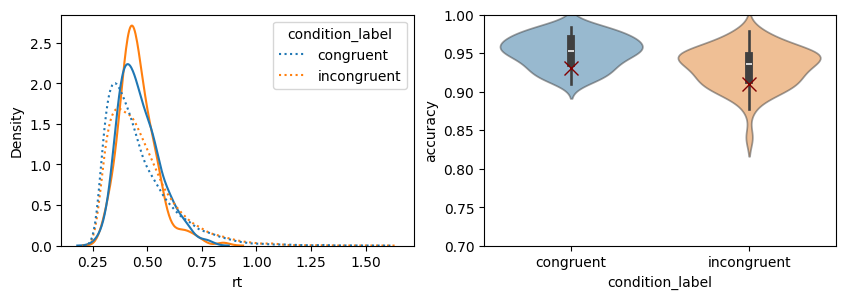

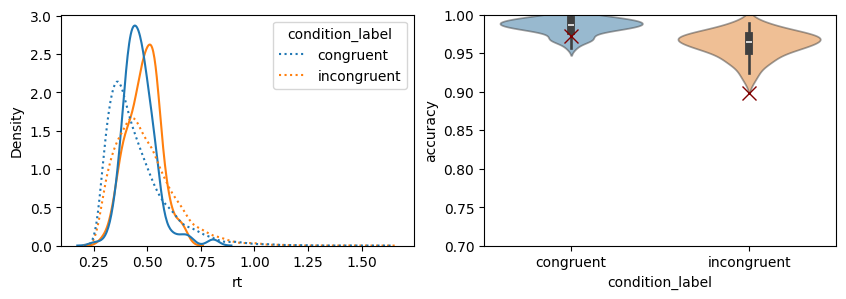

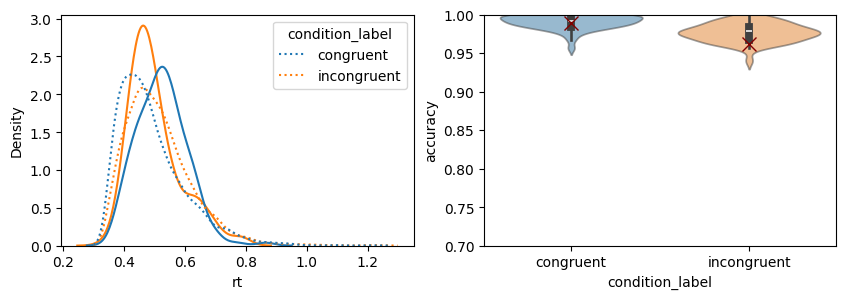

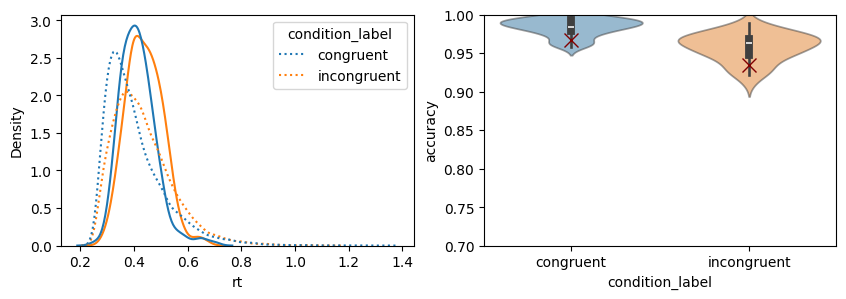

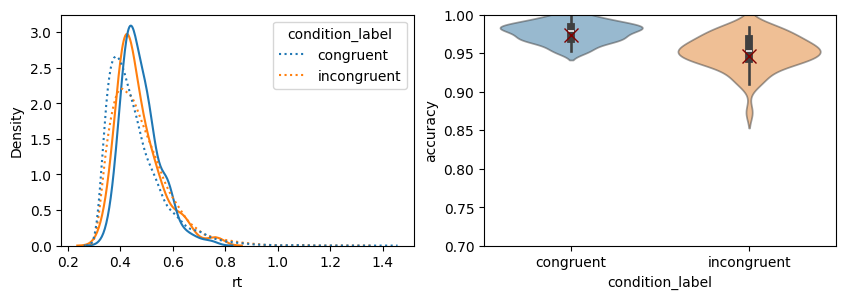

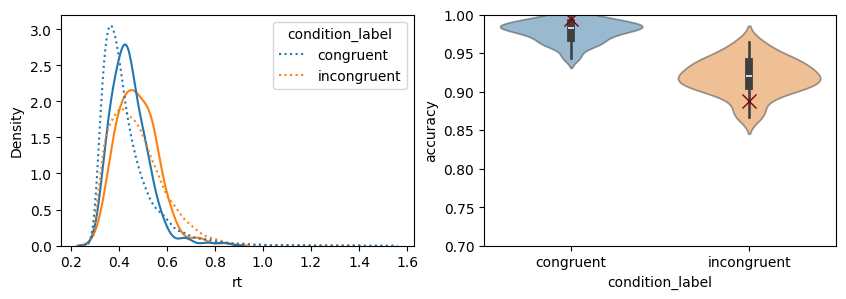

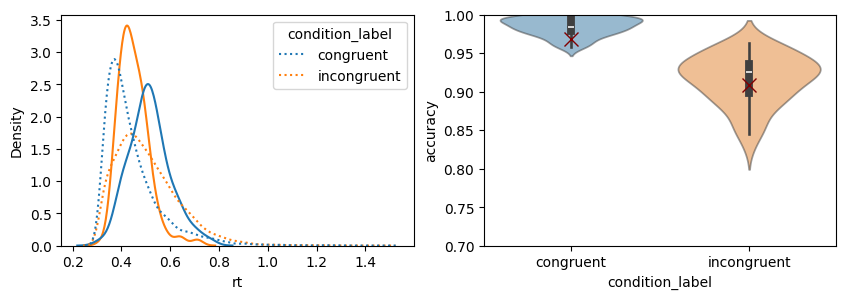

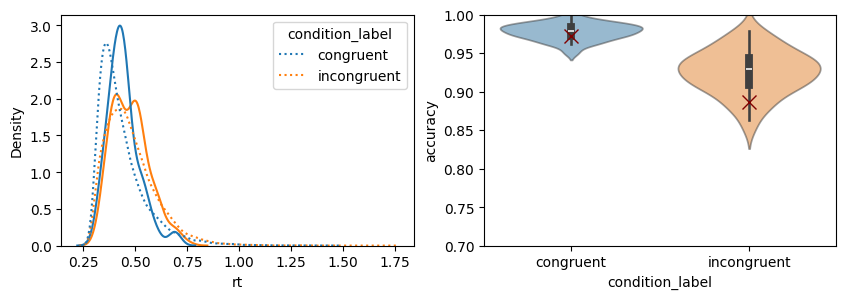

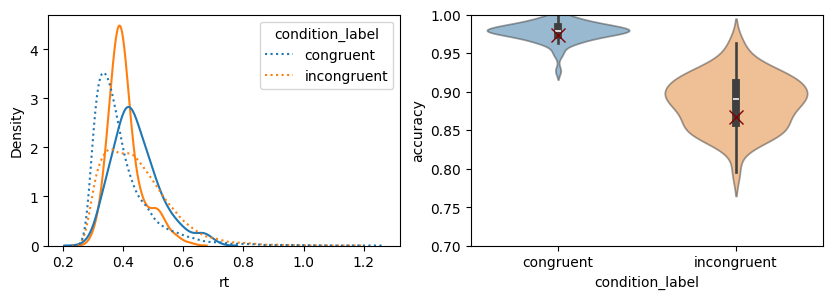

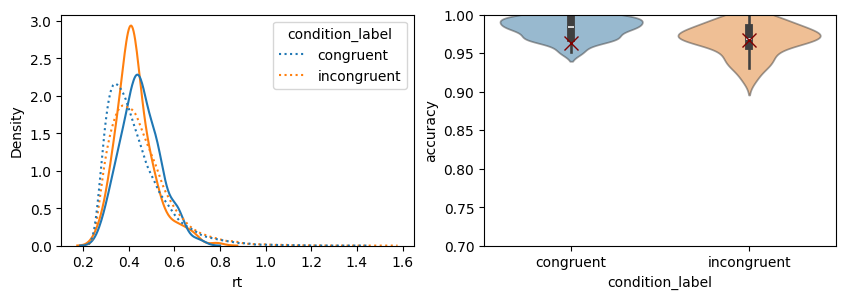

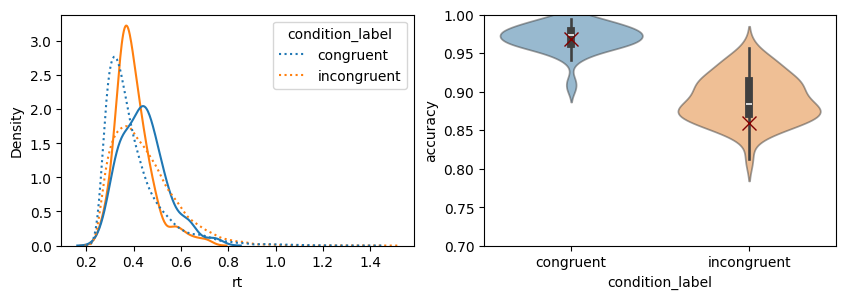

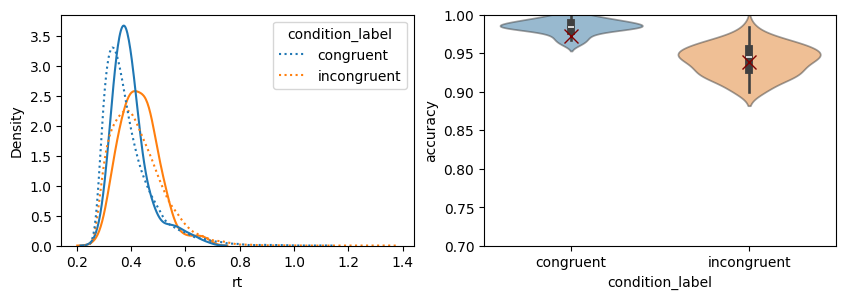

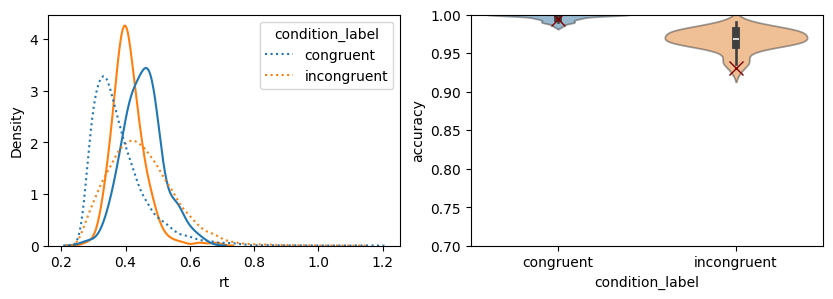

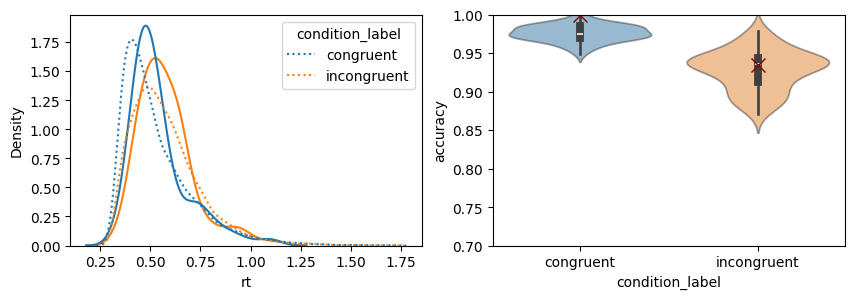

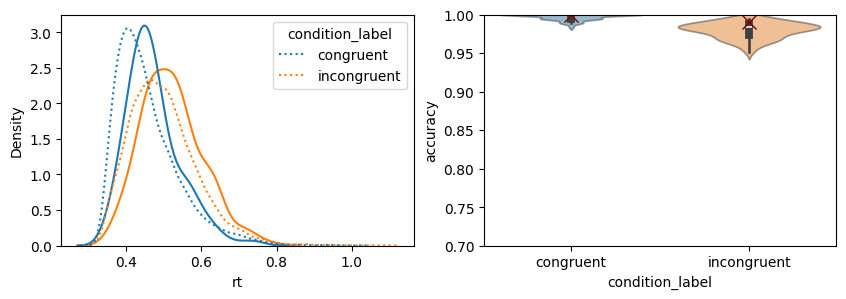

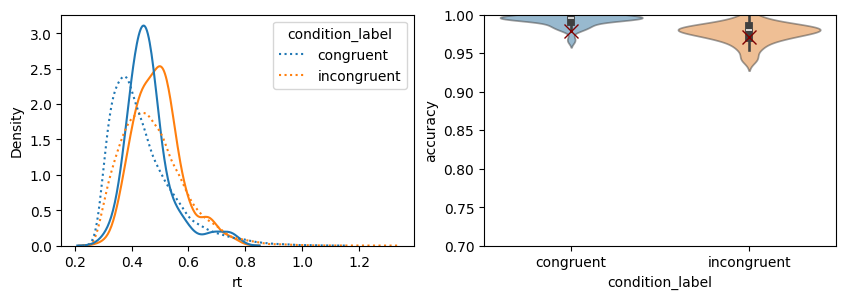

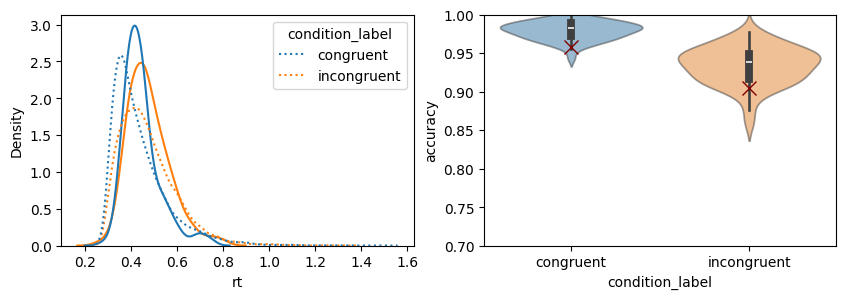

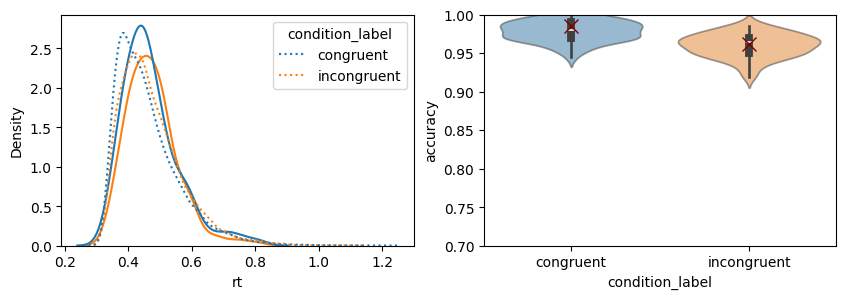

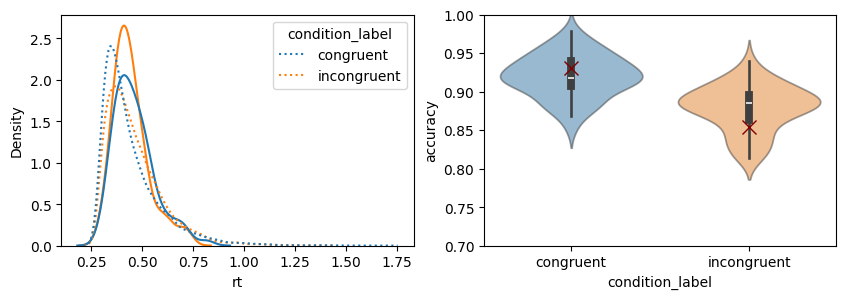

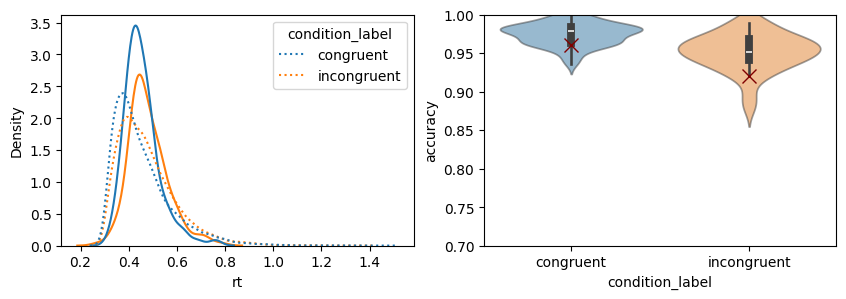

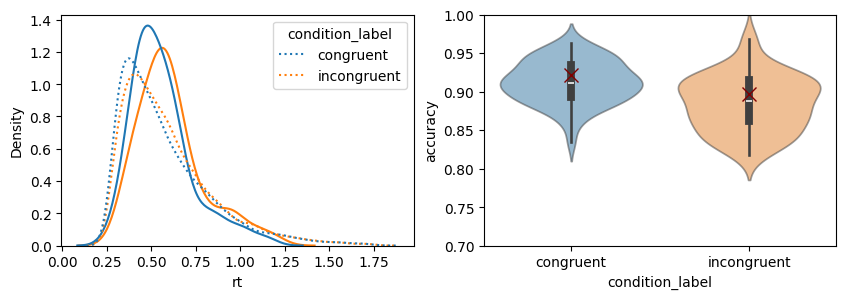

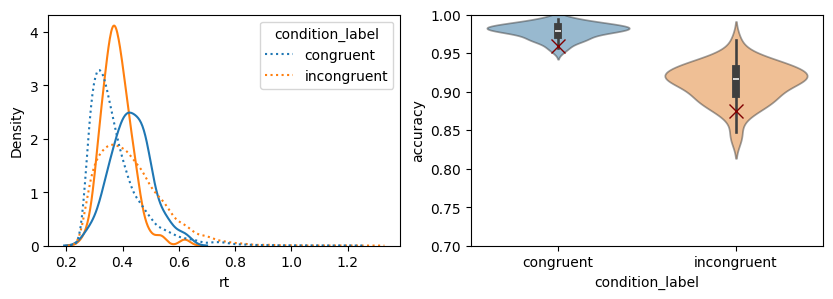

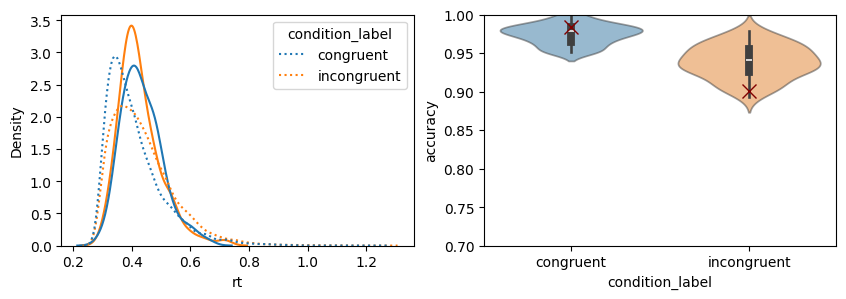

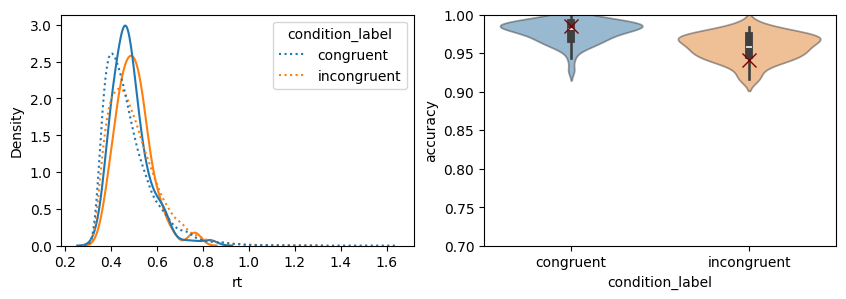

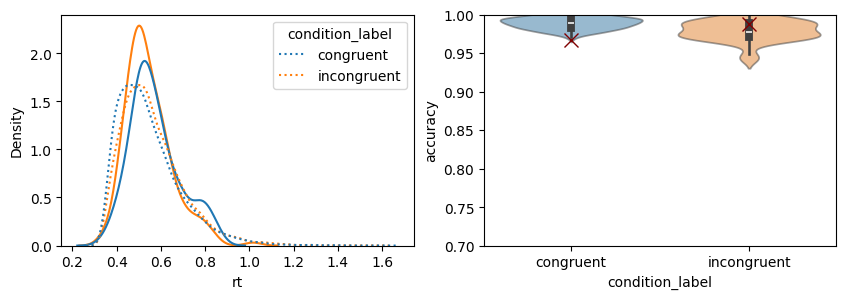

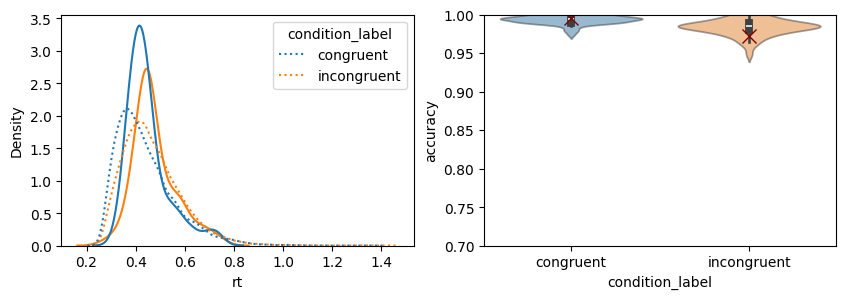

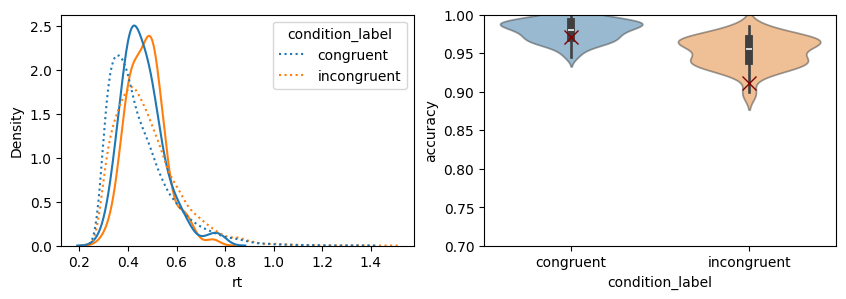

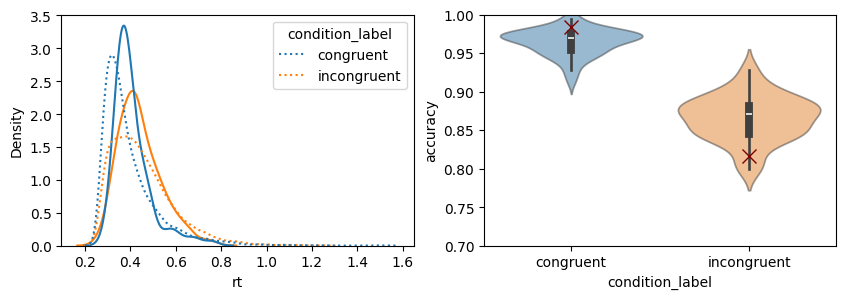

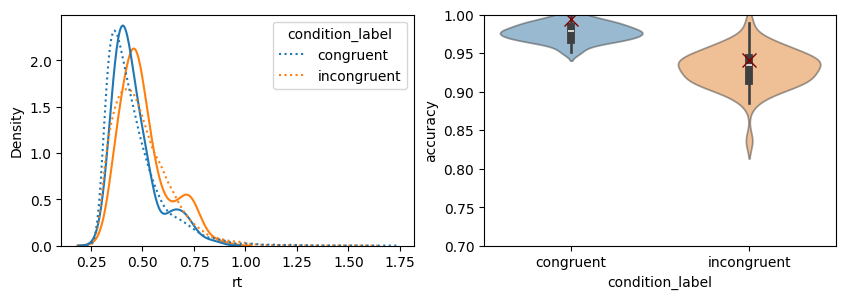

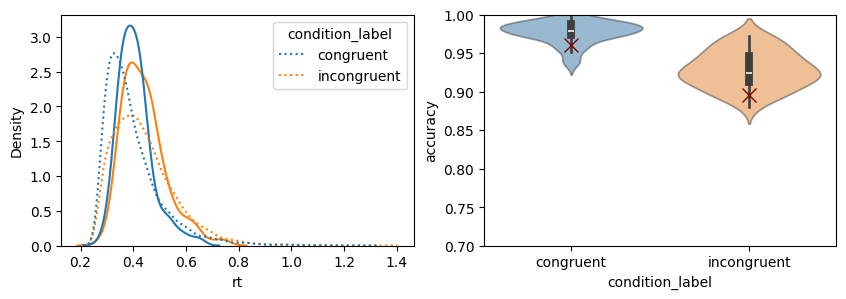

In [ ]:

for part in parts:
    
    # filter sample data for given participant and narrow spacing
    part_data_samples = samples_complete[samples_complete["participant"]==part]

    part_data_samples = part_data_samples[part_data_samples["spacing"] == "narrow"]
    
    # filter empirical data for given participant and narrow spacing
    part_data = empirical_data[empirical_data["participant"] == part]

    part_data = part_data[part_data["spacing_num"] == 1]
    
    part_data["condition_label"] = part_data["congruency_num"].map({0.0: "congruent", 1.0: "incongruent"})
    
    # compute empirical accuracy
    empirical_accuracies_congruent.append(np.mean(part_data[part_data["congruency_num"] == 0]["accuracy"]))
    empirical_accuracies_incongruent.append(np.mean(part_data[part_data["congruency_num"] == 1]["accuracy"]))
    
    
    # resimulate data
    data_resimulated = resim_data(part_data_samples, num_obs = part_data.shape[0])
    
    # exclude non-convergents
    data_resimulated = data_resimulated[data_resimulated["rt"] != -1]
    
    # recode congruency
    data_resimulated["condition_label"] = data_resimulated["conditions"].map({0.0: "congruent", 1.0: "incongruent"})
    
    # compute resimulated data
    resimulated_accuracies_congruent.append(np.mean(data_resimulated[data_resimulated["conditions"] == 0]["accuracy"]))
    resimulated_accuracies_incongruent.append(np.mean(data_resimulated[data_resimulated["conditions"] == 1]["accuracy"]))
    
    # plot individual fit
    fig, axes = plt.subplots(1,2, figsize=(10,3))

    sns.kdeplot(part_data, x="rt", hue="condition_label", ax=axes[0], label = "Observed")

    sns.kdeplot(data_resimulated, x="rt", hue="condition_label", ax=axes[0], linestyle=":", label = "Predicted")

    aggr_data = part_data.groupby("congruency_num").mean("accuracy")

    # compute mean accuracy empirical data
    aggr_data_resim = data_resimulated.groupby("condition_label").mean("accuracy")
    aggr_data.reset_index(inplace=True)
    
    # recode congruency empirical data
    aggr_data["condition_label"] = aggr_data["congruency_num"].map({0.0: "congruent", 1.0: "incongruent"})
    
    # compute accuracies resimulated data
    aggr_data_resim = data_resimulated.groupby(["num_resim", "conditions"]).mean("accuracy")
    aggr_data_resim.reset_index(inplace=True)
    
    # recode congruency resimulated data
    aggr_data_resim["condition_label"] = aggr_data_resim["conditions"].map({0.0: "congruent", 1.0: "incongruent"})

    sns.violinplot(aggr_data_resim, x="condition_label", 
                y="accuracy", hue="condition_label", ax=axes[1], label = "Resimulated", alpha=0.5)
    axes[1].plot(aggr_data["condition_label"], aggr_data["accuracy"], "x", color="maroon", markersize=10)
    plt.ylim(0.7, 1)


<Axes: ylabel='Count'>

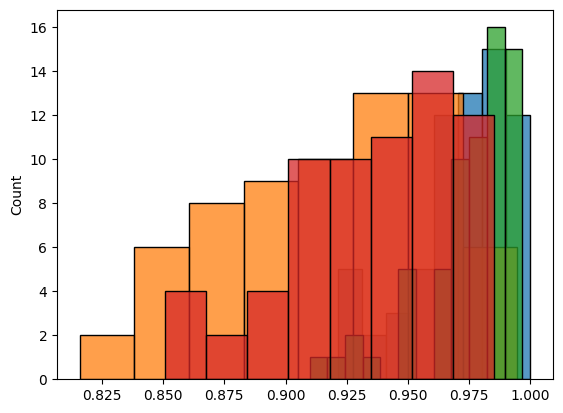

In [31]:
sns.histplot(empirical_accuracies_congruent, label="Empirical Congruent")
sns.histplot(empirical_accuracies_incongruent, label="Empirical Incongruent")
sns.histplot(resimulated_accuracies_congruent, label="Resimulated Congruent")
sns.histplot(resimulated_accuracies_incongruent, label="Resimulated Incongruent")

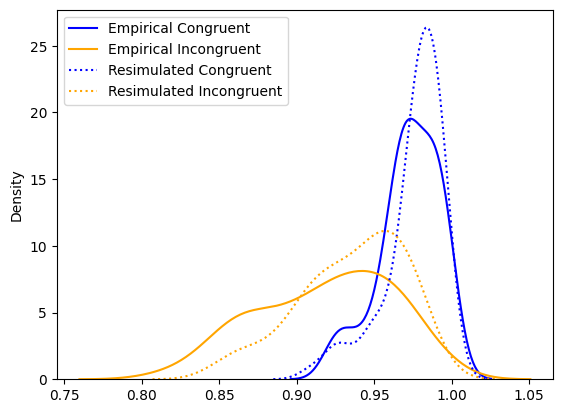

In [37]:
sns.kdeplot(empirical_accuracies_congruent, label="Empirical Congruent", color="blue")
sns.kdeplot(empirical_accuracies_incongruent, label="Empirical Incongruent", color="orange")
sns.kdeplot(resimulated_accuracies_congruent, linestyle=":", label="Resimulated Congruent", color="blue")
sns.kdeplot(resimulated_accuracies_incongruent, linestyle=":", label="Resimulated Incongruent", color="orange")
plt.legend()

In [17]:
data_resimulated

rt  accuracy  conditions  num_obs  num_resim  partricipant
0    0.425380       1.0           0      369          0           985
1    0.583380       1.0           0      369          0           985
2    0.433380       1.0           0      369          0           985
3    0.323380       1.0           0      369          0           985
4    0.348380       1.0           0      369          0           985
..        ...       ...         ...      ...        ...           ...
364  0.538307       1.0           1      369         49           985
365  0.366307       1.0           1      369         49           985
366  0.291307       1.0           1      369         49           985
367  0.301307       0.0           1      369         49           985
368  0.365307       1.0           1      369         49           985

[18450 rows x 6 columns]

## Delta Functions

In [236]:
def delta_functions(data, quantiles = np.arange(0,1, 0.1), 
                  grouping_labels=["participant", "condition_label"],
                  rt_var="rt",
                  congruency_name="condition_label"):
    

    quantile_data = data.groupby(grouping_labels)[rt_var].quantile(quantiles).reset_index()
    
    quantile_data.rename(columns={"level_2": "quantiles"}, inplace=True)

    quantile_data_wide = quantile_data.pivot(index="quantiles", columns=congruency_name, values=rt_var)

    quantile_data_wide["delta"] = quantile_data_wide["incongruent"] - quantile_data_wide["congruent"]

    quantile_data_wide["mean_qu"] = (quantile_data_wide["incongruent"] + quantile_data_wide["congruent"])/2

    return quantile_data_wide
        

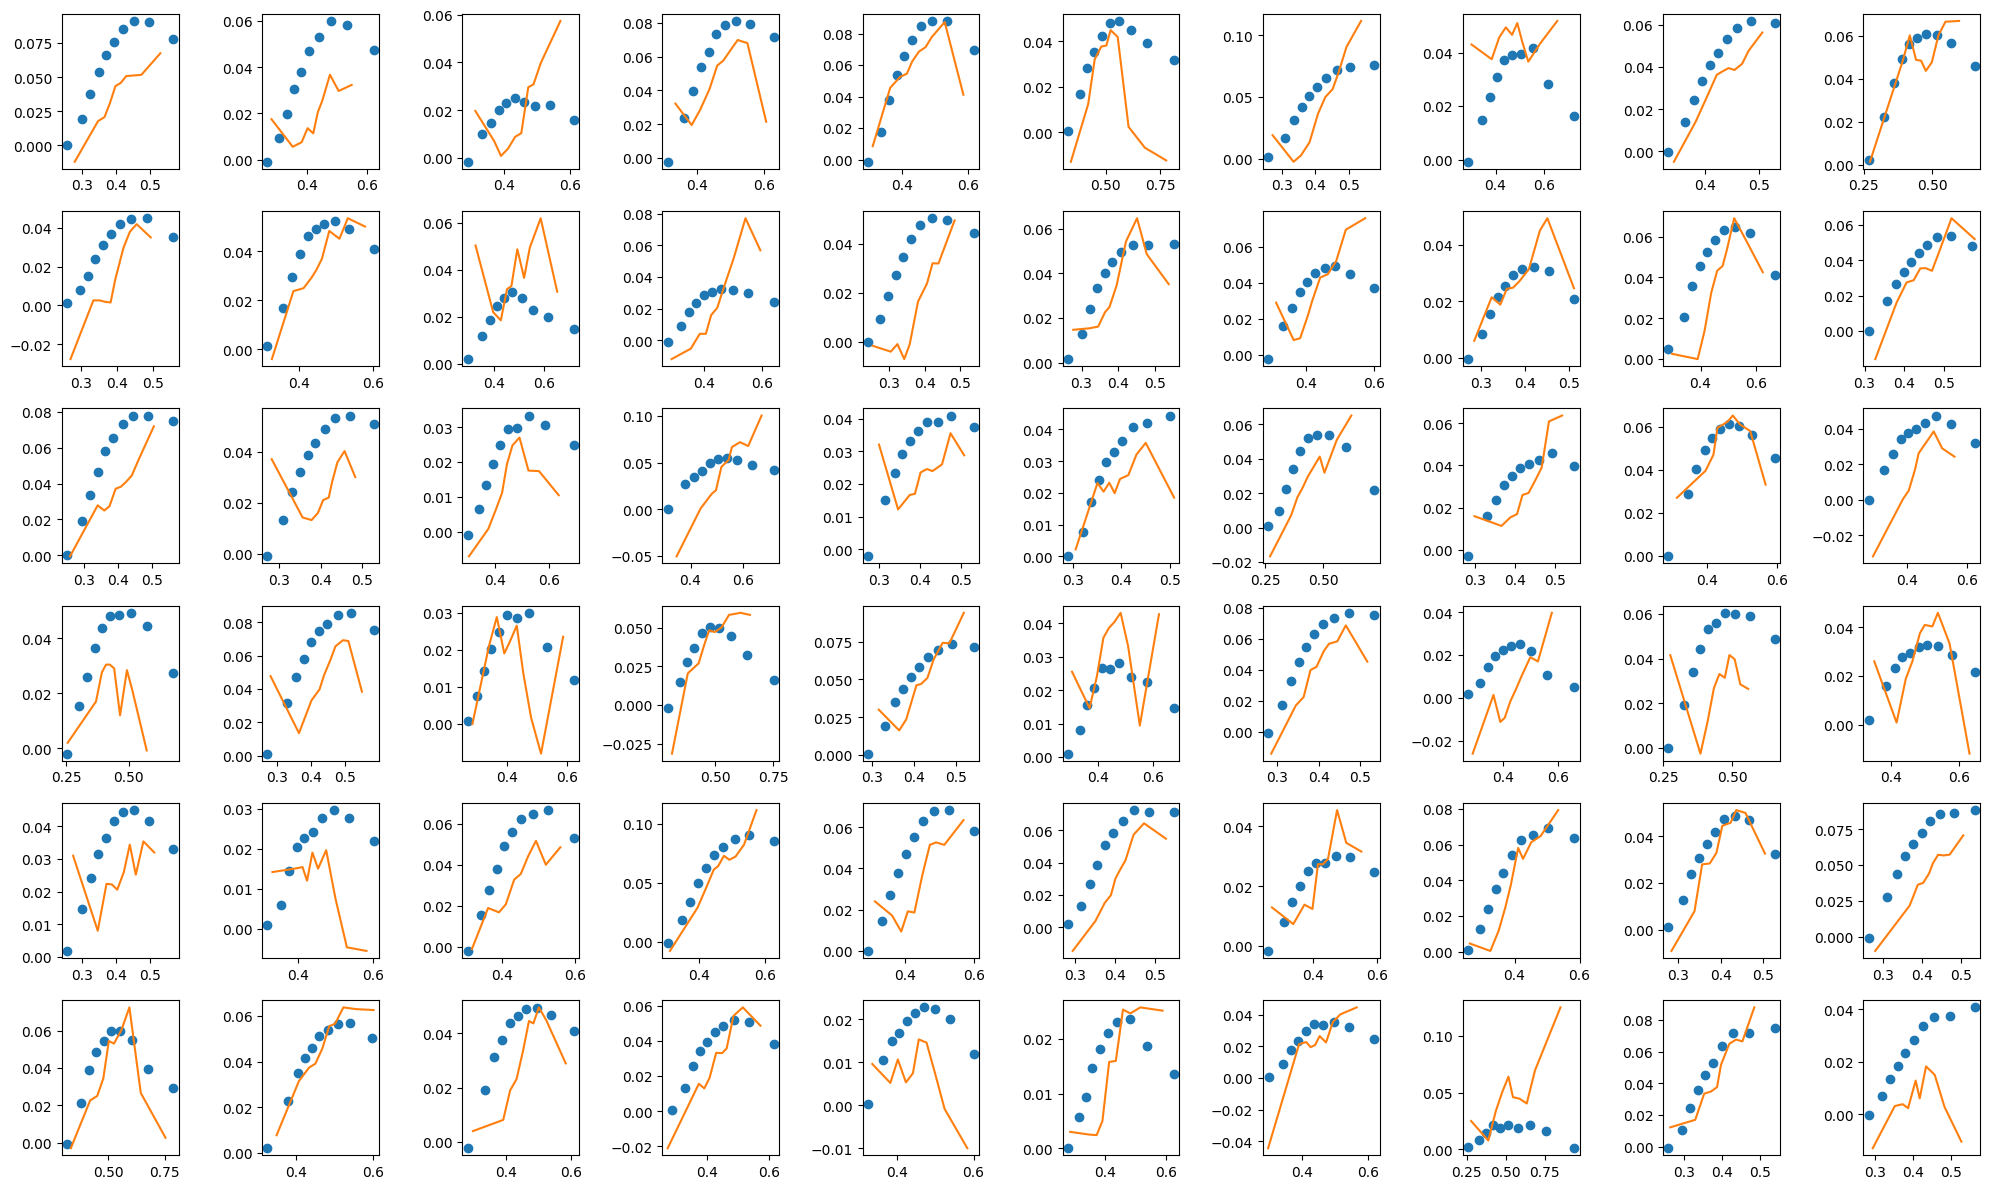

In [243]:
fig, axes = plt.subplots(6, 10, figsize=(20,12))

axes = axes.flatten()

for part, ax in zip(parts, axes):
    
    # filter sample data for given participant and narrow spacing
    part_data_samples = data_complete[data_complete["participant"]==part]

    part_data_samples = part_data_samples[part_data_samples["spacing"] == "narrow"]

    # filter empirical data for given participant and narrow spacing
    part_data = empirical_data[empirical_data["participant"] == part]

    part_data = part_data[part_data["spacing_num"] == 1]

    part_data["condition_label"] = part_data["congruency_num"].map({0.0: "congruent", 1.0: "incongruent"})

    # resimulate data
    data_resimulated = resim_data(part_data_samples, num_obs = part_data.shape[0])

    # exclude non-convergents
    data_resimulated = data_resimulated[data_resimulated["rt"] != -1]

    # recode congruency
    data_resimulated["condition_label"] = data_resimulated["conditions"].map({0.0: "congruent", 1.0: "incongruent"})

    quantiles = np.arange(0,1, 0.1)

    quantile_data_wide_resim = delta_functions(data_resimulated, quantiles = np.arange(0, 1, 0.1))

    quantile_data_wide_empirical = delta_functions(part_data, quantiles = np.arange(0, 1, 0.1))

    ax.plot(quantile_data_wide_resim["mean_qu"] ,quantile_data_wide_resim["delta"] ,"o")
    ax.plot(quantile_data_wide_empirical["mean_qu"] ,quantile_data_wide_empirical["delta"] )

fig.tight_layout()
    

## Reliability 

In [144]:
narrow_data_even=narrow_data.iloc[::2]

narrow_data_odd=narrow_data.iloc[1::2]

post_samples_narrow_even = dmc_helpers.fit_empirical_data(narrow_data_even, approximator)

post_samples_narrow_odd = dmc_helpers.fit_empirical_data(narrow_data_odd, approximator)

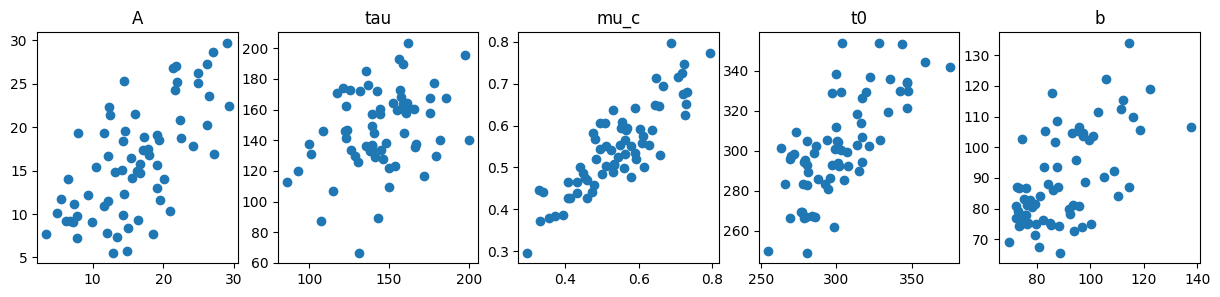

In [244]:
post_median_odd = post_samples_narrow_odd.groupby("participant").median()

post_median_even = post_samples_narrow_even.groupby("participant").median()

fig, axes = plt.subplots(1,5, figsize=(15,3))
for p, ax in zip(param_names, axes):
    ax.plot(post_median_odd[p], post_median_even[p], "o")
    ax.plot([])
    
    ax.set_title(p)

## Trial dependency

In [10]:
simulator = DMC(
    prior_means=np.array([16., 111., 0.5, 322., 75.]), 
    prior_sds=np.array([10., 47., 0.13, 40., 23.]),
    tmax=1500
    # contamination_probability=.05
)

adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .sqrt("num_obs")
    .concatenate(["A", "tau", "mu_c", "mu_r", "b"], into="inference_variables")
    .concatenate(["rt", "accuracy", "conditions"], into="summary_variables")
    .standardize(include="inference_variables")
    .rename("num_obs", "inference_conditions")
)
# Create inference net 
inference_net = bf.networks.CouplingFlow(coupling_kwargs=dict(subnet_kwargs=dict(dropout=0.1)))

# inference_net = bf.networks.FlowMatching(subnet_kwargs=dict(dropout=0.1))

summary_net = bf.networks.SetTransformer(summary_dim=32, num_seeds=2, dropout=0.1)

workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    initial_learning_rate=1e-4,
    inference_network=inference_net,
    summary_network=summary_net,
    checkpoint_filepath='../checkpoints',
    checkpoint_name= "simons_crazy_net_test_metrics",
    inference_variables=["A", "tau", "mu_c", "mu_r", "b"]
)



In [47]:
file_path = '../data/data_offline_training/data_offline_training.pickle'

# train_data = simulator.sample(50000)

# with open(file_path, 'wb') as file:
#     pickle.dump(train_data, file)

with open(file_path, 'rb') as file:
    train_data = pickle.load(file)
    
        
val_file_path = '../data/data_offline_training/data_offline_validation.pickle'

with open(val_file_path, 'rb') as file:
    val_data = pickle.load(file)
    
train_data.keys()

dict_keys(['A', 'tau', 'mu_c', 't0', 'b', 'rt', 'accuracy', 'conditions', 'num_obs'])

In [ ]:
train_data["mu_r"] = train_data.pop("t0")

val_data["mu_r"] = val_data.pop("t0")

# val_data.keys()

In [23]:
%%time
history = workflow.fit_offline(train_data, epochs=1, batch_size=32, validation_data=val_data)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 258s 165ms/step - loss: 2.7021 - loss/inference_loss: 2.7021 - val_loss: 2.4188 - val_loss/inference_loss: 2.4188


INFO:bayesflow:Training is now finished.
            You can find the trained approximator at '../checkpoints/simons_crazy_net_test_metrics.simons_crazy_net_test_metrics.keras'.
            To load it, use approximator = keras.saving.load_model(...).


CPU times: user 4min 15s, sys: 2.5 s, total: 4min 18s
Wall time: 4min 17s


In [122]:
approximator = keras.saving.load_model("../checkpoints/simons_crazy_net_test_metrics.keras")

data = simulator.sample(10)

samples = approximator.sample(conditions=data, num_samples=1000)

bf.diagnostics.metrics.calibration_error(samples, data)

{'values': VariableArray([0.03447368, 0.07184211, 0.07605263, 0.42394737, 0.37394737]),
 'metric_name': 'Calibration Error',
 'variable_names': ['A', 'tau', 'mu_c', 'mu_r', 'b']}

In [120]:
import pandas as pd

list_metrics = []

num_max_obs = 500

for n_obs in range(5, num_max_obs, 20):
    
    simulator.num_obs = n_obs
    
    val_data = simulator.sample(200)
    
    metrics_table=workflow.compute_default_diagnostics(test_data=val_data)
    
    metrics_table["num_obs"] = n_obs
    
    list_metrics.append(metrics_table)
    
data_set_metrics = pd.concat(list_metrics)

data_set_metrics

A       tau      mu_c      mu_r         b  \
NRMSE                  0.287864  0.326023  0.279874  0.185241  0.252931   
Posterior Contraction  0.224140  0.029860  0.535445  0.826286  0.402872   
Calibration Error      0.049211  0.043026  0.290395  0.225395  0.194868   
NRMSE                  0.256757  0.359789  0.192594  0.103762  0.168395   
Posterior Contraction  0.109561  0.000000  0.760513  0.889855  0.722741   
...                         ...       ...       ...       ...       ...   
Posterior Contraction  0.492626  0.027810  0.918668  0.985951  0.962461   
Calibration Error      0.011447  0.013158  0.207368  0.410395  0.282895   
NRMSE                  0.208512  0.267188  0.098560  0.067064  0.091801   
Posterior Contraction  0.535093  0.025321  0.928028  0.987486  0.968217   
Calibration Error      0.013947  0.012368  0.194868  0.371974  0.322895   

                       num_obs  
NRMSE                        5  
Posterior Contraction        5  
Calibration Error            5  
NRMSE                       25  
Posterior Contraction       25  
...                        ...  
Posterior Contraction      465  
Calibration Error          465  
NRMSE                      485  
Posterior Contraction      485  
Calibration Error          485  

[75 rows x 6 columns]

In [117]:
data_set_metrics.reset_index(inplace=True, names="metric")
data_set_metrics


ValueError: cannot insert metric, already exists

In [118]:
data_metrics_long =data_set_metrics.melt(id_vars=["metric", "num_obs"], value_vars=["A", "tau", "mu_c", "mu_r", "b"], var_name="parameter", value_name="score")

AttributeError: 'Axes' object has no attribute 'set_'

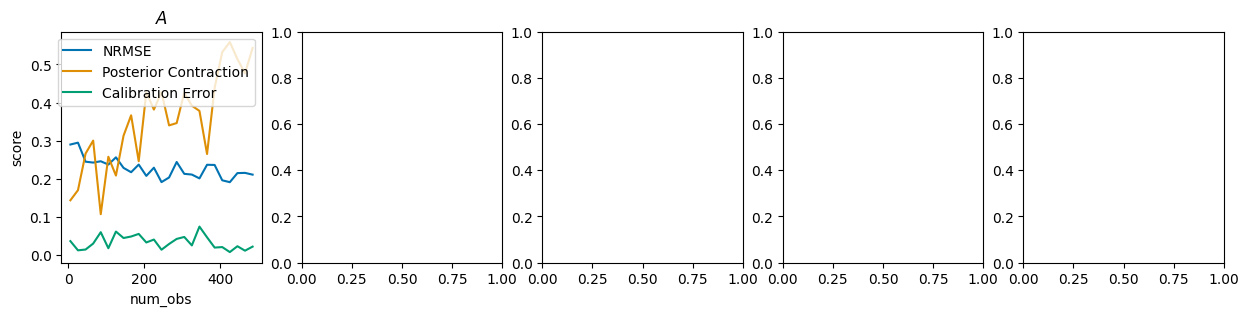

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

param_names =  ["A", "tau", "mu_c", "mu_r", "b"]

fig, axes = plt.subplots(1,5, figsize=(15,3))

for p, ax in zip(param_names, axes):
    
    suff = "$\\" if p in ["tau", "mu_c", "mu_r"] else "$"

    label = suff + p + "$"
    
    sns.lineplot(data_metrics_long[data_metrics_long["parameter"] == p], x="num_obs", y="score", hue="metric", ax=ax, palette="colorblind")
    ax.set_title(label)
    ax.legend(title="")
    ax.set_
    if p != "b":
        ax.get_legend().remove()

fig.tight_layout()
# sns.lineplot(data_metrics_long, x="num_obs", y ="score", col="parameter")

In [42]:
metrics_table["n_obs"] = 10

metrics_table

A       tau      mu_c      mu_r         b  n_obs
NRMSE                  0.282219  0.284907  0.162782  0.110885  0.136611     10
Posterior Contraction  0.198050  0.025385  0.719526  0.874438  0.799351     10
Calibration Error      0.011974  0.013421  0.116974  0.102763  0.081447     10